# Synthefy Forecasting API: Anomaly Detection

In [ ]:
import json
from typing import Any, Dict, List, Optional, Tuple

import numpy as np

import httpx
import pandas as pd
from pydantic import BaseModel, Field, field_validator

import matplotlib.pyplot as plt
import seaborn as sns


# --------------------------------------------------- Setup API ---------------------------------------------------
X_API_KEY = "XXXX-XXXX"  # Replace with your API key
BASE_URL = "https://prod.synthefy.com"
client = httpx.Client(base_url=BASE_URL, timeout=30.0)
ENDPOINT = "api/foundation_models/forecast/stream"

# --------------------------------------------------- End API Setup ---------------------------------------------------

# ## Understanding the Data Models
#
# Our API uses Pydantic models to ensure data validation and type safety. Let's explore the key components:


# --------------------------------------------------- Data Model(s) ---------------------------------------------------

class FoundationModelForecastStreamRequest(BaseModel):
    # --------------- User uploaded data ---------------
    historical_timestamps: List[str]

    # from df.to_dict(orient='list')
    historical_timeseries_data: Dict[str, List[Any]]
    targets: List[str]  # must be present as keys in historical_timeseries_data

    # must be present in historical_timeseries_data if provided
    covariates: List[str] = Field(default_factory=list)
    # --------------- End user uploaded data ---------------

    # --------------- Synthefy Database context ---------------
    synthefy_metadata_info_combined: None # Unused
    synthefy_metadata_leak_idxs: Optional[List[int]] = None # Unused
    # --------------- End Synthefy Database context ---------------

    # --------------- Data for Forecasting ---------------
    # the timestamps for which we want to predict the targets' values
    forecast_timestamps: List[str]
    # from df.to_dict(orient='list'); future metadata that will be used
    future_timeseries_data: Dict[str, List[Any]] | None
    # --------------- End Data for Forecasting ---------------

    # Dict used to add constant context (will be same for each timestamp/repeated for the dfs)
    static_context: Dict[str, float | int | str] | None
    prompt: str | None  # Prompt/description of the task/data/etc

    quantiles: List[float] | None  # which quantiles to return



def make_api_call(request: FoundationModelForecastStreamRequest):
# Make the API call
    response = client.post(
        ENDPOINT,
        json=request.model_dump(),
        headers={"X-API-Key": X_API_KEY},
    )
    return response


# ## Helper Functions
#
# We provide a comprehensive helper function to convert your data into the format our API expects:


def convert_df_to_synthefy_request(
    df: pd.DataFrame,
    future_df: pd.DataFrame | None,
    target_cols: List[str],
    forecast_timestamps: List[str],
    timestamp_col: Optional[str] = None,  # auto-detect if not provided
    covariate_cols: List[str] = [],
) -> FoundationModelForecastStreamRequest:
    """Convert pandas DataFrames into a Synthefy API request.

    This function handles all the data preparation needed to make a forecast request.
    It supports:
    - Automatic timestamp detection
    - Multiple target variables
    - Optional covariates
    - Future known data
    - External data integration

    Args:
        df: Historical data DataFrame
        future_df: Future known data DataFrame (can be empty)
        target_cols: Columns to forecast
        forecast_timestamps: Timestamps to forecast for
        timestamp_col: Column containing timestamps (auto-detected if None)
        covariate_cols: Additional columns to use as features
        synthefy_metadata_info_combined: External data sources to use
        synthefy_metadata_leak_idxs: Which external data sources to use

    Returns:
        A properly formatted request object for the Synthefy API
    """
    df_copy = df.copy()
    # auto-detect timestamp column if not provided
    if timestamp_col is None:
        for col in df.columns:
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                timestamp_col = col
                break
    else:
        df.loc[:, timestamp_col] = pd.to_datetime(df[timestamp_col])
        if future_df is not None:
            future_df.loc[:, timestamp_col] = pd.to_datetime(
                future_df[timestamp_col]
            )
    if not timestamp_col:
        raise ValueError("No timestamp column found")

    historical_timestamps = [
        ts.isoformat() for ts in df[timestamp_col].tolist()
    ]

    # drop timestamp column from df
    df_copy = df_copy.drop(columns=[timestamp_col])

    df_copy = df_copy[target_cols + covariate_cols]
    historical_timeseries_data = df_copy.to_dict(orient="list")
    historical_timeseries_data = {
        str(k): v for k, v in historical_timeseries_data.items()
    }

    # Get the future_timeseries_data (don't give the target columns)
    future_timeseries_data = None
    if future_df is not None:
        future_timeseries_data = future_df[covariate_cols].to_dict(
            orient="list"
        )
        future_timeseries_data = {
            str(k): v for k, v in future_timeseries_data.items()
        }

    # create request object
    request = FoundationModelForecastStreamRequest(
        historical_timestamps=historical_timestamps,
        historical_timeseries_data=historical_timeseries_data,
        targets=target_cols,
        covariates=covariate_cols,
        synthefy_metadata_info_combined=None,
        synthefy_metadata_leak_idxs=None,
        forecast_timestamps=forecast_timestamps,
        future_timeseries_data=future_timeseries_data,
        static_context=None,  # Not yet supported
        prompt=None,  # Not yet supported
        quantiles=None,
    )

    return request

def convert_response_to_df(
    response: Dict[str, Any],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Convert API response to pandas DataFrames for easy analysis.

    Args:
        response: The API response dictionary

    Returns:
        Tuple of (forecast_df, quantiles_df) where:
        - forecast_df contains the point forecasts
        - quantiles_df contains the forecast quantiles
    """
    forecast_dict = {k: v for k, v in response["forecast"].items()}
    quantiles = {k: v for k, v in response["forecast_quantiles"].items()}
    forecast_df = pd.DataFrame(forecast_dict)
    forecast_df["timestamp"] = pd.to_datetime(response["forecast_timestamps"])
    quantiles_df = pd.DataFrame(quantiles)
    quantiles_df["timestamp"] = pd.to_datetime(response["forecast_timestamps"])
    return forecast_df, quantiles_df


def compute_metrics_df(forecast_df_copy:pd.DataFrame, future_df_copy:pd.DataFrame, target_cols:List[str]):
    if not isinstance(target_cols, list):
        target_cols = [target_cols]

    # Join future_df and forecast_df on Date (future_df) and timestamp (forecast_df)
    merged_df = future_df_copy.merge(
        forecast_df_copy,
        left_on="timestamp",
        right_on="timestamp",
        how="inner",
        suffixes=("_actual", "_forecast"),
    )
    cols_to_keep = ["timestamp"] + [f"{target_col}_actual" for target_col in target_cols] + [f"{target_col}_forecast" for target_col in target_cols]
    merged_df = merged_df[cols_to_keep]

    df_with_metrics = merged_df.copy()
    for target_col in target_cols:
        # Compute per-row metrics correctly (row-wise, not constant)
        # Compute per-row metrics
        df_with_metrics[f"SE_{target_col}"] = (df_with_metrics[f"{target_col}_actual"] - df_with_metrics[f"{target_col}_forecast"]) ** 2
        df_with_metrics[f"AE_{target_col}"] = (df_with_metrics[f"{target_col}_actual"] - df_with_metrics[f"{target_col}_forecast"]).abs()
        epsilon = 1e-8
        df_with_metrics[f"APE_{target_col}"] = (
            (df_with_metrics[f"{target_col}_actual"] - df_with_metrics[f"{target_col}_forecast"]).abs() / (df_with_metrics[f"{target_col}_actual"].abs() + epsilon)
        ) * 100

        # Compute median metrics
        mse = df_with_metrics[f"SE_{target_col}"].mean()
        mae = df_with_metrics[f"AE_{target_col}"].mean()
        mape = df_with_metrics[f"APE_{target_col}"].mean()

        # Store median metrics as new columns (same value for all rows, for easy reference)
        df_with_metrics[f"MSE_{target_col}"] = mse
        df_with_metrics[f"MAE_{target_col}"] = mae
        df_with_metrics[f"MAPE_{target_col}"] = mape

    return df_with_metrics




In [2]:
df = pd.read_csv("/home/raimi/solar_dataset.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [3]:
df

,timestamp,solar_power_generated,temperature,cloud_cover,sunshine_hours,precipitation
0,2022-01-01 00:00:00,5.22,2.21,0.78,4.02,0.58
1,2022-01-01 12:00:00,6.80,-0.33,0.58,5.53,0.47
2,2022-01-02 00:00:00,4.42,2.85,0.40,4.02,0.00
3,2022-01-02 12:00:00,9.11,6.35,0.32,5.54,0.00
4,2022-01-03 00:00:00,7.13,-0.64,0.17,4.03,0.20
...,...,...,...,...,...,...
1455,2023-12-29 12:00:00,5.88,-6.92,0.90,4.65,0.78
1456,2023-12-30 00:00:00,3.86,3.17,1.00,3.18,1.43
1457,2023-12-30 12:00:00,3.20,1.68,0.94,2.22,1.03
1458,2023-12-31 00:00:00,5.82,5.35,1.00,4.02,0.37


### Now, anomalies can be detected with your method of choice (point-wise, sum, etc)

## Example 1: Forecasting with Exogenous Data

##### Let's predict each time series in the dataset.


In [4]:
historical_df = df[df["timestamp"] < pd.to_datetime("2023-12-15")]
future_df = df[df["timestamp"] >= pd.to_datetime("2023-12-15")]

target_cols = ["solar_power_generated"]

# Create a basic forecast request
request = convert_df_to_synthefy_request(
    df=historical_df,
    future_df=None,  # No future data in this example
    target_cols=target_cols,
    forecast_timestamps=[
        "2023-12-15T00:00:00",
        "2023-12-15T12:00:00",
        "2023-12-16T00:00:00",
        "2023-12-16T12:00:00",
        "2023-12-17T00:00:00",
        "2023-12-17T12:00:00",
        "2023-12-18T00:00:00",
        "2023-12-18T12:00:00",
        "2023-12-19T00:00:00",
        "2023-12-19T12:00:00",
        "2023-12-20T00:00:00",
        "2023-12-20T12:00:00",
        "2023-12-21T00:00:00",
        "2023-12-21T12:00:00",
        "2023-12-22T00:00:00",
        "2023-12-22T12:00:00",
        "2023-12-23T00:00:00",
        "2023-12-23T12:00:00",
        "2023-12-24T00:00:00",
        "2023-12-24T12:00:00",
        "2023-12-25T00:00:00",
        "2023-12-25T12:00:00",
        "2023-12-26T00:00:00",
        "2023-12-26T12:00:00",
        "2023-12-27T00:00:00",
        "2023-12-27T12:00:00",
        "2023-12-28T00:00:00",
        "2023-12-28T12:00:00",
        "2023-12-29T00:00:00",
        "2023-12-29T12:00:00",
        "2023-12-30T00:00:00",
        "2023-12-30T12:00:00",
        "2023-12-31T00:00:00",
        "2023-12-31T12:00:00",
    ],
    timestamp_col="timestamp",
    covariate_cols=["cloud_cover"],
)

In [5]:
# Make the API call
response = make_api_call(request)

# Convert response to DataFrames for analysis
forecast_df_exogenous, quantiles_df = convert_response_to_df(response.json())
exogenous_metrics_df = compute_metrics_df(forecast_df_exogenous, future_df, target_cols=target_cols)


## Example 3: Leaking Test-time data

##### Now, let's enhance our forecast by incorporating "known" future data. If there are exogenous variables that are not "targets"/KPIs, we can use these to enhance predictions. In this example, we can use the weather forecasts for cloud cover and sunshine hours.


In [6]:
request.forecast_timestamps
[ts.isoformat() for ts in future_df["timestamp"].tolist()]

['2023-12-15T00:00:00',
 '2023-12-15T12:00:00',
 '2023-12-16T00:00:00',
 '2023-12-16T12:00:00',
 '2023-12-17T00:00:00',
 '2023-12-17T12:00:00',
 '2023-12-18T00:00:00',
 '2023-12-18T12:00:00',
 '2023-12-19T00:00:00',
 '2023-12-19T12:00:00',
 '2023-12-20T00:00:00',
 '2023-12-20T12:00:00',
 '2023-12-21T00:00:00',
 '2023-12-21T12:00:00',
 '2023-12-22T00:00:00',
 '2023-12-22T12:00:00',
 '2023-12-23T00:00:00',
 '2023-12-23T12:00:00',
 '2023-12-24T00:00:00',
 '2023-12-24T12:00:00',
 '2023-12-25T00:00:00',
 '2023-12-25T12:00:00',
 '2023-12-26T00:00:00',
 '2023-12-26T12:00:00',
 '2023-12-27T00:00:00',
 '2023-12-27T12:00:00',
 '2023-12-28T00:00:00',
 '2023-12-28T12:00:00',
 '2023-12-29T00:00:00',
 '2023-12-29T12:00:00',
 '2023-12-30T00:00:00',
 '2023-12-30T12:00:00',
 '2023-12-31T00:00:00',
 '2023-12-31T12:00:00']

In [7]:
# Split our data into historical and future portions
historical_df = df[df["timestamp"] < pd.to_datetime("2023-12-15")]
future_df = df[df["timestamp"] >= pd.to_datetime("2023-12-15")]

target_cols_future_leak = ["solar_power_generated"]
# Create a request with future known data
request = convert_df_to_synthefy_request(
    df=historical_df,
    future_df=future_df,
    target_cols=target_cols_future_leak,
    forecast_timestamps=[ts.isoformat() for ts in future_df["timestamp"].tolist()],
    timestamp_col="timestamp",
    covariate_cols=["cloud_cover"],
)

# Make the API call
response = make_api_call(request)

# Convert response to DataFrames for analysis
forecast_df_future_leak, quantiles_df = convert_response_to_df(response.json())
future_leak_metrics_df = compute_metrics_df(forecast_df_future_leak, future_df, target_cols=target_cols_future_leak)



/tmp/ipykernel_3892785/376164358.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


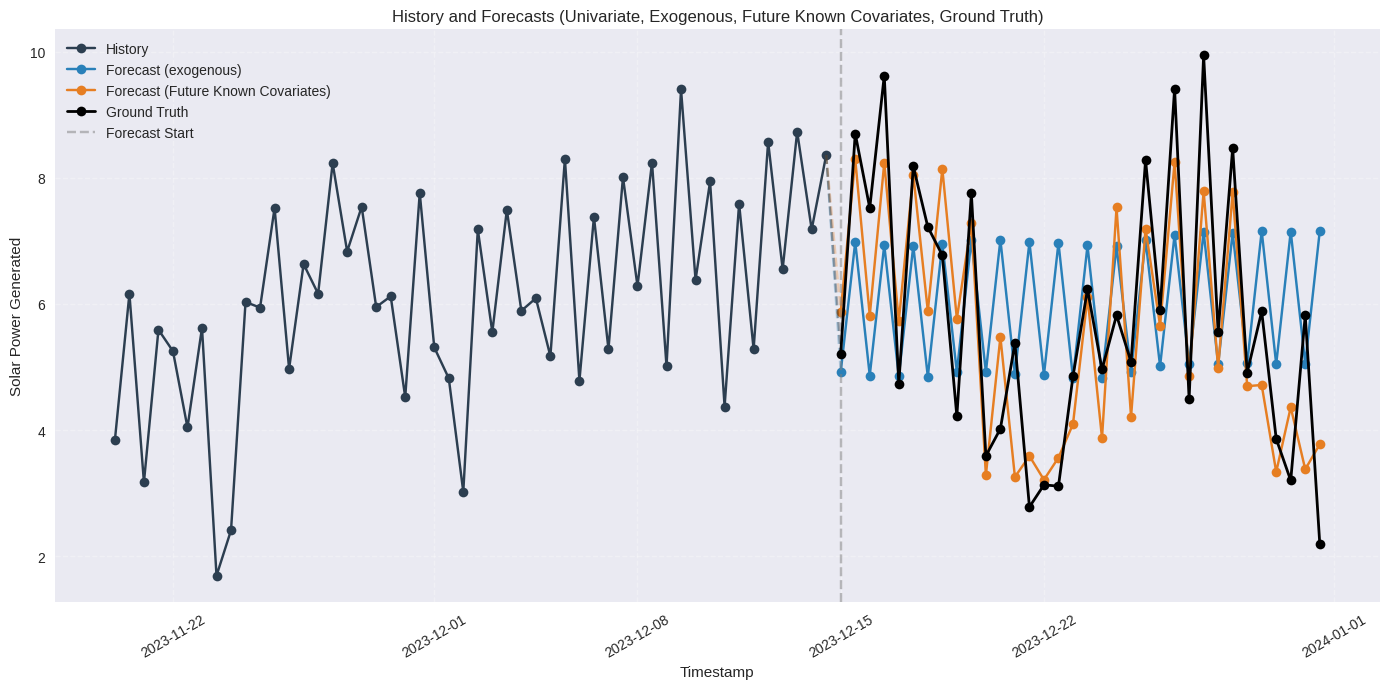

In [8]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
colors = ['#2C3E50', '#27AE60', '#2980B9', '#E67E22']

# Plot historical data, all 3 forecasts, and ground truth on the same chart
fig, ax = plt.subplots(figsize=(14, 7))

# Plot historical actuals (only last N points)
historical_df_for_plot = historical_df.tail(50)
ax.plot(
    historical_df_for_plot['timestamp'],
    historical_df_for_plot['solar_power_generated'],
    label='History',
    color=colors[0],
    marker='o'
)

# Plot forecast 2: exogenous
ax.plot(
    forecast_df_exogenous['timestamp'],
    forecast_df_exogenous['solar_power_generated'],
    label='Forecast (exogenous)',
    color=colors[2],
    marker='o'
)

# Plot forecast 3: Future leak
ax.plot(
    forecast_df_future_leak['timestamp'],
    forecast_df_future_leak['solar_power_generated'],
    label='Forecast (Future Known Covariates)',
    color=colors[3],
    marker='o'
)

# Plot ground truth (future_df) in black
if not future_df.empty:
    ax.plot(
        future_df['timestamp'],
        future_df['solar_power_generated'],
        label='Ground Truth',
        color='black',
        marker='o',
        linewidth=2,
        zorder=10
    )

# Add connecting lines from last history point to first forecast of each type
last_history_date = historical_df_for_plot['timestamp'].iloc[-1]
last_history_value = historical_df_for_plot['solar_power_generated'].iloc[-1]

# exogenous
if len(forecast_df_exogenous) > 0:
    first_forecast_date_multi = forecast_df_exogenous['timestamp'].iloc[0]
    first_forecast_value_multi = forecast_df_exogenous['solar_power_generated'].iloc[0]
    ax.plot([last_history_date, first_forecast_date_multi],
            [last_history_value, first_forecast_value_multi],
            color=colors[2], linestyle='--', alpha=0.3)

# Future leak
if len(forecast_df_future_leak) > 0:
    first_forecast_date_leak = forecast_df_future_leak['timestamp'].iloc[0]
    first_forecast_value_leak = forecast_df_future_leak['solar_power_generated'].iloc[0]
    ax.plot([last_history_date, first_forecast_date_leak],
            [last_history_value, first_forecast_value_leak],
            color=colors[3], linestyle='--', alpha=0.3)

# Ground Truth connecting line
if not future_df.empty:
    first_gt_date = future_df['timestamp'].iloc[0]
    first_gt_value = future_df['solar_power_generated'].iloc[0]
    ax.plot([last_history_date, first_gt_date],
            [last_history_value, first_gt_value],
            color='black', linestyle='--', alpha=0.3)

# Add vertical line at forecast start
if not future_df.empty:
    forecast_start = future_df['timestamp'].iloc[0]
    ax.axvline(forecast_start, color='gray', linestyle='--', alpha=0.5, label='Forecast Start')

ax.set_ylabel('Solar Power Generated')
ax.set_xlabel('Timestamp')
ax.set_title('History and Forecasts (Univariate, Exogenous, Future Known Covariates, Ground Truth)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='x', labelrotation=30)
plt.tight_layout()
plt.show()


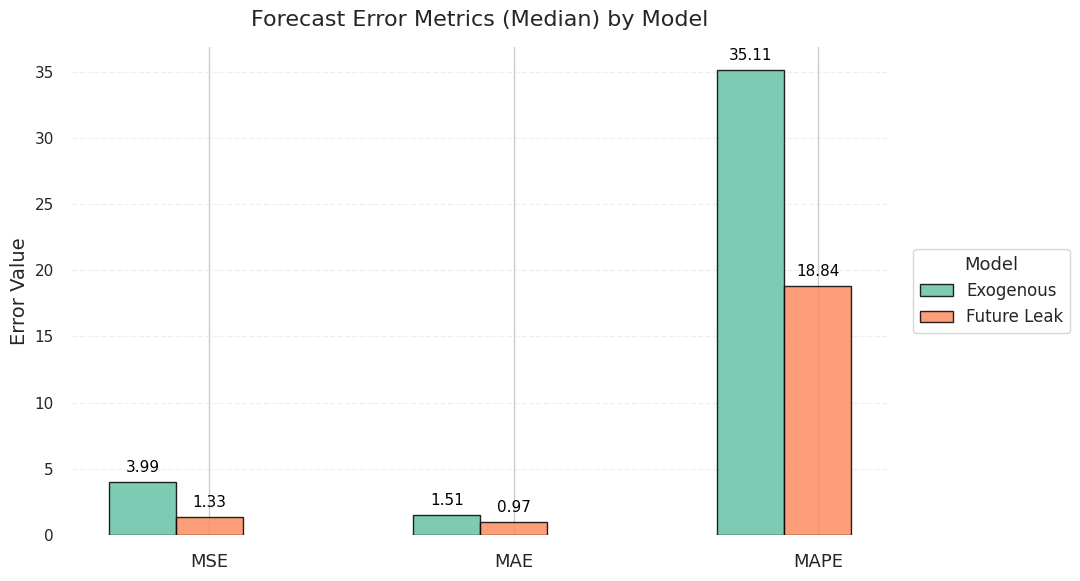

In [9]:
# Enhanced bar chart for forecast error metrics (using median)
# Set a modern style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 13})

metrics_dfs = [
    (exogenous_metrics_df, 'Exogenous'),
    (future_leak_metrics_df, 'Future Leak')
]
metrics_to_plot = ['MSE_solar_power_generated', 'MAE_solar_power_generated', 'MAPE_solar_power_generated']
metric_labels = ['MSE', 'MAE', 'MAPE']
model_labels = [label for _, label in metrics_dfs]

# Prepare data for bar plot (use median instead of mean)
medians = np.array([df[metrics_to_plot].median().values for df, _ in metrics_dfs])

x = np.arange(len(metrics_to_plot))
width = 0.22
colors = sns.color_palette("Set2", n_colors=len(metrics_dfs))

fig, ax = plt.subplots(figsize=(11, 6))
bars = []
for i, (label, median_vals) in enumerate(zip(model_labels, medians)):
    bar = ax.bar(x + i*width - width, median_vals, width, label=label, color=colors[i], edgecolor='black', alpha=0.85)
    bars.append(bar)
    # Add value labels on top of bars
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, color='black')

ax.set_ylabel('Error Value', fontsize=14)
ax.set_title('Forecast Error Metrics (Median) by Model', fontsize=16, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=13)
# Fix legend location: place it outside the plot to the right
ax.legend(title='Model', fontsize=12, title_fontsize=13, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()